### Imports

In [2]:
import pandas as pd
from sklearn.preprocessing  import RobustScaler
from sklearn.preprocessing  import OrdinalEncoder
from sklearn.preprocessing  import OneHotEncoder
import seaborn as sns
from umap import UMAP
import numpy as np
from sklearn.naive_bayes import GaussianNB

sns.set_theme(context="paper", style="ticks")
random_state = 42

Load data

In [3]:
train = pd.read_csv("data\\train.csv")
test = pd.read_csv("data\\test.csv")

test_ID = test.PassengerId

Proprocessing

In [4]:
def preprocess(df, fit, oh_enc, ordinal_enc):
    df["Deck"] = pd.DataFrame(df.Cabin.str.extract("([A-Z])", expand=False))
    categorical_cols = ["Sex", "Embarked"]
    drop_cols = ["Ticket", "Cabin", "Name", "PassengerId", "Sex", "Embarked", "Deck"]

    if fit:
        df = pd.concat([df, pd.DataFrame(oh_enc.fit_transform(df[categorical_cols].astype("str")))], axis=1)
        df = pd.concat([df, pd.DataFrame(ordinal_enc.fit_transform(np.array(df.Deck).reshape(-1,1)))], axis=1)

    else:
        df = pd.concat([df, pd.DataFrame(oh_enc.transform(df[categorical_cols].astype("str")))], axis=1)
        df = pd.concat([df, pd.DataFrame(ordinal_enc.transform(np.array(df.Deck).reshape(-1,1)))], axis=1)

    df.drop(labels=drop_cols, axis=1, inplace=True)
    df.fillna(-1, inplace=True)
    return (df)

In [5]:
oh_enc = OneHotEncoder(sparse=False)
ordinal_enc = OrdinalEncoder(categories=[["A", "B", "C", "D", "E", "F", "G", "T", np.nan]])

train = preprocess(train, fit=True, oh_enc=oh_enc, ordinal_enc=ordinal_enc)
test = preprocess(test, fit=False, oh_enc=oh_enc, ordinal_enc=ordinal_enc)

In [6]:
scaler = RobustScaler()

train_y = train.Survived
train.drop("Survived", axis=1, inplace=True)

train_X = scaler.fit_transform(train)
test = scaler.transform(test)

C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [11]:
reducer = UMAP(
    n_components=4,
    n_neighbors=100,
    min_dist=0,
    target_weight=0.5,
    metric="correlation",
    random_state=random_state
)

embedding_train = reducer.fit_transform(
    X=train_X,
    y=train_y
)

embedding_test = reducer.transform(
    X=test
)

Plot training data

<AxesSubplot:>

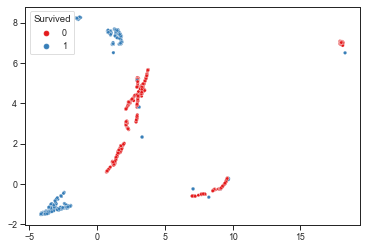

In [12]:
sns.scatterplot(
    x=embedding_train[:,0],
    y=embedding_train[:,1],
    hue=train_y,
    # style=clusterlabels,
    palette="Set1",
    s=10
)

Train a Gaussian Naive Bayes

In [13]:
gnb = GaussianNB()
pred = gnb.fit(
    X=train_X,
    y=train_y).predict(test).astype("int")

Plot test data

<AxesSubplot:>

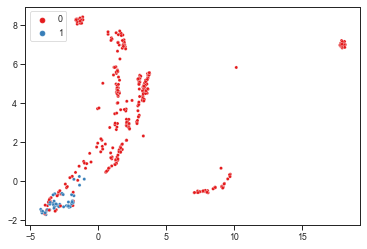

In [14]:
sns.scatterplot(
    x=embedding_test[:,0],
    y=embedding_test[:,1],
    hue=pred,
    # style=clusterlabels,
    palette="Set1",
    s=10
    )

Save predictions as csv

In [15]:
submission = pd.DataFrame(columns=["PassengerId", "Survived"], data=zip(test_ID, pred))
submission.to_csv("submission.csv", index=False)